# kernel SVMの実装

「ゼロからつくるPython機械学習プログラミング入門」(八谷大岳)を参考に作成した。特にSVMの実装部分は大きく元にしている。

In [10]:
# -*- coding: utf-8 -*-
import numpy as np
import cvxopt
import cvxopt.solvers
import matplotlib.pylab as plt
import data
import time

## カーネル関数の作成

In [11]:
class kernelFunc():
    # kernelType: 線形カーネル:0,ガウスカーネル:1、多項式カーネル:2
    # kernelParam: カーネルの作成に用いるパラメータ（スカラー）
    ### ガウスカーネルの時はカーネル関数の幅、多項式カーネルの時はカーネル関数の次数を示す
    def __init__(self,kernelType=0,kernelParam=1):
        self.kernelType = kernelType
        self.kernelParam = kernelParam

        # カーネル関数の設定
        kernelFuncs = [self.linear,self.gauss,self.poly]
        self.createMatrix = kernelFuncs[kernelType]

    # 線形カーネル
    def linear(self,X1,X2):
        return np.matmul(X1,X2.T)

    # ガウスカーネル
    def gauss(self,X1,X2):
        X1Num = len(X1)
        X2Num = len(X2)
        
        # X1とX2の全ペア間の距離の計算
        X1 = np.tile(np.expand_dims(X1.T,axis=2),[1,1,X2Num])
        X2 = np.tile(np.expand_dims(X2.T,axis=1),[1,X1Num,1])
        #dist = np.sum(np.square(X1-X2),axis=0)
        
        # グラム行列（X1のデータ数×X2のデータ数）
        K = np.exp(-np.sum(np.square(X1-X2),axis=0)/(2*(self.kernelParam**2)))
        
        return K

    # 多項式カーネル
    
    def poly(self,X1,X2):

        # グラム行列（X1のデータ数×X2のデータ数）
        K = (np.matmul(X1,X2.T)+1)**self.kernelParam

        return K

## SVMの実装

In [12]:
# クラス
class SVM():
    # 1. 学習データの初期化
    
    def __init__(self,X,Y,spptvecThre=0.1,kernelFunc=None):

        # カーネルの設定
        self.kernelFunc = kernelFunc
        
        # 学習データの設定
        self.X = X
        self.Y = Y
        self.dnum = X.shape[0]  # 学習データ数
        self.xdim = X.shape[1]  # 入力の次元数
        
        # サポートベクトルの閾値設定
        self.spptvecThre = 0.1

    # 2.5 ソフトマージンSVMのモデルパラメータを最適化
    def trainSoft(self,C=0.1):
        X = self.kernelFunc.createMatrix(self.X,self.X)
        
        # 行列Pの作成
        # PはYY^TとXX^Tのアダマール積
        P = np.matmul(self.Y,self.Y.T) * X
        P = cvxopt.matrix(P)
        
        # q,L,m,A,bを作成
        q = cvxopt.matrix(-np.ones(self.dnum))
        L1 = np.diag(-np.ones(self.dnum))
        L2 = np.diag(np.ones(self.dnum))
        L = cvxopt.matrix(np.concatenate([L1,L2],axis=0))
        m1 = np.zeros([self.dnum,1])
        m2 = C*np.ones([self.dnum,1])
        m = cvxopt.matrix(np.concatenate([m1,m2],axis=0))
        A = cvxopt.matrix(self.Y.astype(float).T)
        b = cvxopt.matrix(0.0)

        # 二次計画法
        sol = cvxopt.solvers.qp(P,q,L,m,A,b)
        self.lamb = np.array(sol['x'])
        # 'x'がlambdaに対応する
        
        # サポートベクトルのインデックス
        self.spptvecInds = np.where(self.lamb > self.spptvecThre)[0]
        
        # wとbの計算
        self.w = np.matmul((self.lamb*self.Y).T,X).T
        self.b = np.mean(self.Y[self.spptvecInds] - np.matmul(X[self.spptvecInds,:],self.w))
   
    # 3. 予測
    def predict(self,x):
        x = self.kernelFunc.createMatrix(x,self.X)
        y = np.matmul(x,self.w) + self.b
        return np.sign(y),y
    
    # 4. 正解率を計算する
    def accuracy(self,X,Y):
        predict,_ = self.predict(X)
        return np.sum(predict==Y)/len(X)

    # 5. プロット
    def plotModel2D(self,X=[],Y=[],spptvecInds=[],xLabel="",yLabel="",title="",fName="",isLinePlot=False):
        plt.close()
        
        # 真値のプロット（クラスごとにマーカーを変更）
        plt.plot(X[Y[:,0]==-1,0],X[Y[:,0]==-1,1],'cx',markerSize=14,label="category-1")
        plt.plot(X[Y[:,0]== 1,0],X[Y[:,0]== 1,1],'m.',markerSize=14,label="category+1")

        # 予測値のメッシュの計算
        X1,X2 = plt.meshgrid(plt.linspace(np.min(X[:,0]),np.max(X[:,0]),50),plt.linspace(np.min(X[:,1]),np.max(X[:,1]),50))
        Xmesh = np.hstack([np.reshape(X1,[-1,1]),np.reshape(X2,[-1,1])])
        _,Ymesh = self.predict(Xmesh)
        Ymesh = np.reshape(Ymesh,X1.shape)

        # contourプロット
        CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)

        # カラーバー
        CB = plt.colorbar(CS)
        CB.ax.tick_params(labelsize=14)
        
        # サポートベクトルのプロット
        if len(spptvecInds):
            plt.plot(X[spptvecInds,0],X[spptvecInds,1],'o',color='none',markeredgecolor='r',markersize=18,markeredgewidth=3,label="support vector")

        # 直線のプロット
        if isLinePlot:
            x1 = np.arange(np.min(X[:,0]),np.max(X[:,0]),(np.max(X[:,0]) - np.min(X[:,0]))/100)
            x2 = -(x1*self.w[0]+self.b)/self.w[1]
            plt.plot(x1,x2,'r-',label="f(x)")

        # 各軸の範囲、タイトルおよびラベルの設定
        plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
        plt.ylim([np.min(X[:,1]),np.max(X[:,1])])
        plt.title(title,fontSize=14)
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        plt.legend()

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

In [13]:
def calculate(dataType, kernelType, kernelParam, trainSoftParam):
    # 1. データの作成
    myData = data.classification(negLabel=-1.0,posLabel=1.0)
    myData.makeData(dataType)
    
    # 2. データを学習と評価用に分割
    dtrNum = int(len(myData.X)*0.9)  # 学習データ数
    # 学習データ（全体の90%）
    Xtr = myData.X[:dtrNum]
    Ytr = myData.Y[:dtrNum]

    # 評価データ（全体の10%）
    Xte = myData.X[dtrNum:]
    Yte = myData.Y[dtrNum:]

    # 3. 正規化
    xMean = np.mean(Xtr,axis=0)
    xStd = np.std(Xtr,axis=0)
    Xtr = (Xtr-xMean)/xStd
    Xte = (Xte-xMean)/xStd

    # 4. カーネル関数の作成
    myKernel = kernelFunc(kernelType,kernelParam)

    # 5. SVMのモデルの学習
    start = time.time()
    myModel = SVM(Xtr,Ytr,kernelFunc=myKernel)
    myModel.trainSoft(trainSoftParam)
    elapsed_time = time.time() - start
    
    # 6. SVMモデルの評価
    print(f"model parameter:\nw={myModel.w}\nb={myModel.b}")
    print(f"accuracy of estimation data={myModel.accuracy(Xte,Yte):.2f}")
    print("elasped time:{}".format(elapsed_time) + "[sec]")
    
    # 7. 真値と予測値をプロットする
    myModel.plotModel2D(X=Xtr,Y=Ytr,xLabel=myData.xLabel,yLabel=myData.yLabel,
        title=f"learning accuracy:{myModel.accuracy(Xtr,Ytr):.2f},estimation accuracy:{myModel.accuracy(Xte,Yte):.2f}",
        fName=f"results/kernelSVM_result_{myData.dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
        isLinePlot=True)

     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7408e+01 -1.0521e+02  9e+02  5e+00  4e-15
 1: -8.5213e+00 -7.5968e+01  2e+02  7e-01  4e-15
 2: -4.8772e+00 -3.0582e+01  4e+01  1e-01  5e-15
 3: -4.2849e+00 -1.1352e+01  9e+00  2e-02  2e-15
 4: -4.9700e+00 -7.4521e+00  3e+00  6e-03  2e-15
 5: -5.3798e+00 -6.2923e+00  1e+00  2e-03  1e-15
 6: -5.5150e+00 -5.9036e+00  4e-01  3e-16  2e-15
 7: -5.6384e+00 -5.7380e+00  1e-01  2e-16  1e-15
 8: -5.6692e+00 -5.6924e+00  2e-02  4e-16  2e-15
 9: -5.6788e+00 -5.6816e+00  3e-03  6e-16  2e-15
10: -5.6801e+00 -5.6802e+00  8e-05  5e-16  2e-15
11: -5.6801e+00 -5.6801e+00  8e-07  8e-16  2e-15
Optimal solution found.
model parameter:
w=[[ 2.44106528e+00]
 [-2.40181726e-01]
 [ 3.56449969e+00]
 [ 3.01169126e+00]
 [-3.22306151e-01]
 [ 2.33126836e+00]
 [-5.88868533e-01]
 [ 3.37795230e+00]
 [ 3.26084126e+00]
 [-4.19772805e-01]
 [ 2.55027604e+00]
 [ 2.66617817e-03]
 [ 3.16476279e+00]
 [ 3.17105307e-01]
 [ 2.31710524e+00]
 [ 2.76358881e+00]
 [ 5.89119159e+00

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -9.0418e+00 -9.2075e+01  7e+02  5e+00  4e-14
 1: -4.6100e+00 -6.1111e+01  1e+02  4e-01  2e-14
 2: -3.5817e+00 -2.5295e+01  3e+01  1e-01  2e-14
 3: -3.3415e+00 -1.3671e+01  2e+01  5e-02  1e-14
 4: -3.1166e+00 -7.8912e+00  7e+00  2e-02  1e-14
 5: -2.7559e+00 -4.2102e+00  2e+00  4e-03  1e-14
 6: -2.7962e+00 -3.1247e+00  4e-01  8e-04  8e-15
 7: -2.8197e+00 -2.9095e+00  1e-01  1e-04  9e-15
 8: -2.8351e+00 -2.8597e+00  3e-02  2e-05  9e-15
 9: -2.8434e+00 -2.8446e+00  1e-03  1e-07  1e-14
10: -2.8439e+00 -2.8440e+00  3e-05  3e-09  8e-15
11: -2.8440e+00 -2.8440e+00  8e-07  5e-11  9e-15
Optimal solution found.
model parameter:
w=[[ 4.69186600e+00]
 [-1.09649401e-01]
 [ 2.89112328e+00]
 [ 8.65613962e+00]
 [-7.32598616e-02]
 [ 3.15964703e+00]
 [-2.45371471e-01]
 [ 9.88542619e+00]
 [ 8.91218310e+00]
 [ 1.12222151e-01]
 [ 5.89656530e+00]
 [ 8.33019666e-02]
 [ 2.43811148e+00]
 [ 1.91407183e-01]
 [ 5.71787778e+00]
 [ 6.14041222e+00]
 [ 3.12921062e+01

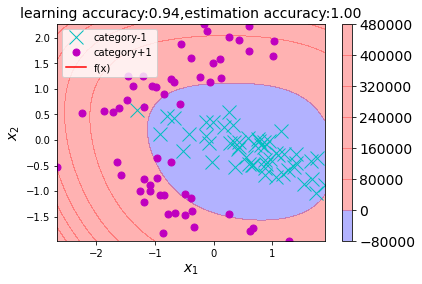

In [14]:
calculate(4, 2, 1, 0.5)
calculate(4, 2, 2, 0.5)
calculate(4, 2, 3, 0.5)
calculate(4, 2, 4, 0.5)

     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


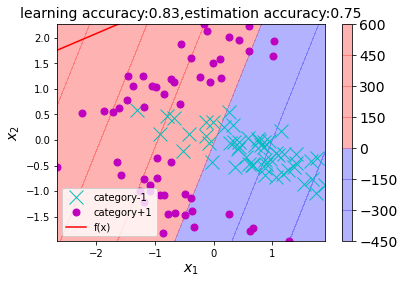

In [19]:
calculate(4, 0, 0.1, 0.5)

     pcost       dcost       gap    pres   dres
 0: -3.0347e+01 -9.7935e+01  4e+02  3e+00  4e-16
 1: -2.6272e+01 -7.3748e+01  5e+01  1e-15  3e-16
 2: -2.8951e+01 -3.3555e+01  5e+00  2e-15  3e-16
 3: -3.0688e+01 -3.1446e+01  8e-01  1e-15  2e-16
 4: -3.0945e+01 -3.1086e+01  1e-01  9e-16  2e-16
 5: -3.1003e+01 -3.1014e+01  1e-02  2e-16  2e-16
 6: -3.1009e+01 -3.1009e+01  4e-04  2e-15  2e-16
 7: -3.1009e+01 -3.1009e+01  8e-06  4e-16  2e-16
Optimal solution found.
model parameter:
w=[[ 0.57632034]
 [-0.81459582]
 [ 0.61417493]
 [ 0.61417503]
 [-1.3512998 ]
 [ 0.54522565]
 [-1.37557284]
 [ 0.57728838]
 [ 0.614175  ]
 [-0.56089131]
 [ 0.61417494]
 [-0.69261823]
 [ 0.61417493]
 [-0.76003316]
 [ 0.56302414]
 [ 0.58272092]
 [ 0.49999977]
 [-0.63758159]
 [ 0.61417386]
 [ 0.56144493]
 [ 0.61417485]
 [ 0.29985423]
 [-1.11465004]
 [ 0.59853309]
 [ 0.61417434]
 [-1.38582503]
 [-0.51196017]
 [-0.90510894]
 [ 0.51948603]
 [ 0.51243026]
 [-1.38582484]
 [ 0.50032824]
 [ 0.56272961]
 [ 0.61417494]
 [-1.38

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.0552e+01 -1.0126e+02  7e+02  5e+00  7e-16
 1: -6.2167e+00 -7.3136e+01  7e+01  4e-02  7e-16
 2: -7.5202e+00 -1.7743e+01  1e+01  5e-03  4e-16
 3: -8.8890e+00 -1.0907e+01  2e+00  6e-04  3e-16
 4: -9.4395e+00 -9.9802e+00  5e-01  3e-05  3e-16
 5: -9.5777e+00 -9.6768e+00  1e-01  2e-06  3e-16
 6: -9.6085e+00 -9.6290e+00  2e-02  2e-07  3e-16
 7: -9.6162e+00 -9.6183e+00  2e-03  2e-08  3e-16
 8: -9.6171e+00 -9.6171e+00  4e-05  2e-10  3e-16
 9: -9.6171e+00 -9.6171e+00  8e-07  2e-12  5e-16
Optimal solution found.
model parameter:
w=[[ 0.47754279]
 [-1.53651543]
 [ 0.55625805]
 [ 0.68866387]
 [-1.72904812]
 [ 0.46348459]
 [-1.8639887 ]
 [ 0.61925845]
 [ 0.74652942]
 [-1.45024743]
 [ 0.55302395]
 [-1.75461108]
 [ 0.46348459]
 [-1.45252965]
 [ 0.46347481]
 [ 0.57508555]
 [ 0.46348458]
 [-1.53651525]
 [ 0.7100366 ]
 [ 0.35497726]
 [ 0.74824089]
 [ 0.18653159]
 [-1.74325641]
 [ 0.67830092]
 [ 0.26284613]
 [-1.89727557]
 [-1.53649132]
 [-1.88094606]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]
 [ 0.41569061]
 [ 0.92352728]
 [-2.03342489]
 [ 0.93462514]
 [ 0.60772211]
 [ 0.81975216]
 [-2.00774463]
 [ 0.34524202]
 [ 0.80062887]
 [-1.90969296]
 [ 0.61529709]
 [ 0.60918274]
 [-2.00242698]
 [-1.71696983]
 [-0.72016581]
 [ 0.36348612]
 [-1.75936927]
 [ 0.31247134]
 [-1.41472014]
 [-0.46463384]
 [-1.86844919]
 [ 0.80405692]
 [ 0.407334

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


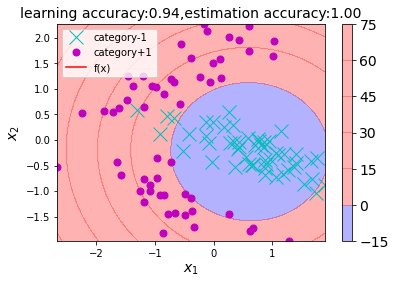

In [15]:
calculate(4, 1, 0.1, 0.5)
calculate(4, 1, 0.8, 0.5)
calculate(4, 1, 1, 0.5)
calculate(4, 1, 3, 0.5)

     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


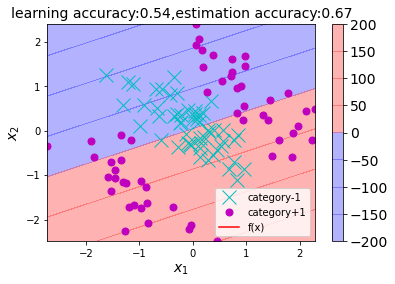

In [20]:
calculate(5, 0, 1, 0.5)

     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


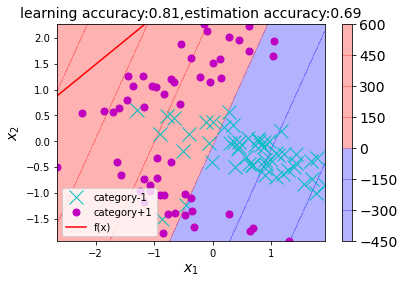

In [21]:
calculate(6, 0, 1, 0.5)

     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -2.3095e+01 -1.2900e+02  1e+03  6e+00  6e-15
 1: -1.0663e+01 -9.9291e+01  2e+02  9e-01  4e-15
 2: -4.6725e+00 -4.2304e+01  6e+01  2e-01  2e-14
 3: -3.3165e+00 -1.1923e+01  1e+01  3e-02  4e-15
 4: -3.9023e+00 -7.5850e+00  4e+00  8e-03  2e-15
 5: -4.3994e+00 -6.0987e+00  2e+00  2e-03  1e-15
 6: -4.6856e+00 -5.4185e+00  8e-01  5e-04  1e-15
 7: -4.8525e+00 -5.1374e+00  3e-01  1e-04  2e-15
 8: -4.9294e+00 -5.0075e+00  8e-02  3e-05  1e-15
 9: -4.9564e+00 -4.9604e+00  4e-03  2e-16  2e-15
10: -4.9583e+00 -4.9584e+00  4e-05  2e-16  2e-15
11: -4.9584e+00 -4.9584e+00  4e-07  2e-16  2e-15
Optimal solution found.
model parameter:
w=[[ 2.99863767e+00]
 [ 8.34358732e-02]
 [ 3.44295966e+00]
 [ 4.68945260e+00]
 [ 1.00870054e-02]
 [ 4.01942434e+00]
 [ 8.70476577e-02]
 [ 7.18450747e+00]
 [ 5.01124189e+00]
 [ 5.24481072e-01]
 [ 4.15412686e+00]
 [ 3.73640371e-02]
 [ 2.98086864e+00]
 [-6.13475630e-02]
 [ 3.46945523e+00]
 [ 5.46460000e+00]
 [ 9.92068836e+00

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -2.0462e+01 -1.0525e+02  8e+02  5e+00  3e-14
 1: -1.0162e+01 -7.6637e+01  2e+02  8e-01  2e-14
 2: -5.4797e+00 -3.6663e+01  6e+01  2e-01  1e-14
 3: -3.4208e+00 -1.4841e+01  2e+01  8e-02  6e-15
 4: -2.4488e+00 -6.8490e+00  7e+00  2e-02  4e-15
 5: -2.5496e+00 -3.8843e+00  2e+00  4e-03  3e-15
 6: -2.6700e+00 -3.2794e+00  6e-01  3e-04  2e-15
 7: -2.8168e+00 -2.9227e+00  1e-01  4e-05  2e-15
 8: -2.8528e+00 -2.8671e+00  1e-02  2e-06  2e-15
 9: -2.8586e+00 -2.8593e+00  7e-04  7e-08  2e-15
10: -2.8589e+00 -2.8589e+00  7e-06  7e-10  3e-15
11: -2.8589e+00 -2.8589e+00  7e-08  7e-12  2e-15
Optimal solution found.
model parameter:
w=[[ 3.89788540e+00]
 [-2.10294326e-01]
 [ 3.18169298e+00]
 [ 6.10061893e+00]
 [-9.10041123e-02]
 [ 5.79672391e+00]
 [-4.62639620e-02]
 [ 1.05017632e+01]
 [ 6.23762935e+00]
 [ 2.70343740e-01]
 [ 5.76450950e+00]
 [ 2.14685120e-01]
 [ 2.69981943e+00]
 [-9.25898324e-02]
 [ 4.69086602e+00]
 [ 7.95193927e+00]
 [ 1.12319304e+01

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.5531e+00 -7.5866e+01  5e+02  4e+00  1e-13
 1: -4.0438e+00 -4.7481e+01  8e+01  4e-01  6e-14
 2: -2.6313e+00 -1.8019e+01  2e+01  1e-01  3e-14
 3: -2.3846e+00 -8.5176e+00  9e+00  4e-02  1e-14
 4: -2.2795e+00 -6.4784e+00  7e+00  2e-02  9e-15
 5: -1.9931e+00 -4.1210e+00  4e+00  9e-03  2e-14
 6: -1.7894e+00 -2.2929e+00  8e-01  2e-03  6e-15
 7: -1.7171e+00 -1.8658e+00  1e-01  3e-16  9e-15
 8: -1.7748e+00 -1.7879e+00  1e-02  4e-16  4e-15
 9: -1.7798e+00 -1.7817e+00  2e-03  2e-16  5e-15
10: -1.7806e+00 -1.7807e+00  4e-05  5e-16  6e-15
11: -1.7807e+00 -1.7807e+00  5e-07  2e-16  6e-15
Optimal solution found.
model parameter:
w=[[ 4.79824461e+00]
 [-1.53814998e-01]
 [ 3.77735026e+00]
 [ 1.03313663e+01]
 [-3.31014822e-02]
 [ 1.01388324e+01]
 [-4.34127757e-02]
 [ 1.84104694e+01]
 [ 1.00143451e+01]
 [-9.42754614e-02]
 [ 7.97496645e+00]
 [ 3.47043215e-02]
 [ 3.05929061e+00]
 [-5.26783541e-01]
 [ 7.34654035e+00]
 [ 1.32502491e+01]
 [ 4.13776203e+01

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


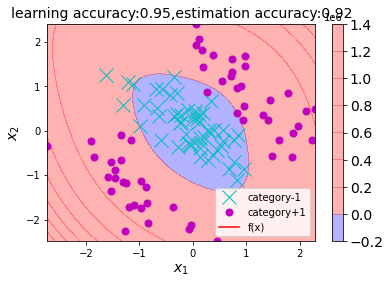

In [17]:
calculate(5, 2, 1, 0.5)
calculate(5, 2, 2, 0.5)
calculate(5, 2, 3, 0.5)
calculate(5, 2, 4, 0.5)

     pcost       dcost       gap    pres   dres
 0: -3.0830e+01 -9.4620e+01  4e+02  3e+00  4e-16
 1: -2.6822e+01 -7.0704e+01  4e+01  1e-15  3e-16
 2: -2.9622e+01 -3.3959e+01  4e+00  3e-15  2e-16
 3: -3.1335e+01 -3.2013e+01  7e-01  5e-15  2e-16
 4: -3.1587e+01 -3.1696e+01  1e-01  5e-15  2e-16
 5: -3.1635e+01 -3.1642e+01  7e-03  3e-15  2e-16
 6: -3.1639e+01 -3.1639e+01  4e-04  5e-16  2e-16
 7: -3.1639e+01 -3.1639e+01  2e-05  3e-15  2e-16
Optimal solution found.
model parameter:
w=[[ 0.57336997]
 [-0.72788303]
 [ 0.61930867]
 [ 0.61930869]
 [-1.36748967]
 [ 0.53317734]
 [-1.30350325]
 [ 0.55232552]
 [ 0.61930889]
 [-0.54832704]
 [ 0.61930869]
 [-0.75452709]
 [ 0.61930867]
 [-0.82705777]
 [ 0.599596  ]
 [ 0.53008293]
 [ 0.49999973]
 [-0.59967555]
 [ 0.61742004]
 [ 0.56317005]
 [ 0.61930844]
 [ 0.5044002 ]
 [-1.01498028]
 [ 0.59477503]
 [ 0.6193061 ]
 [-1.38069128]
 [-0.45353614]
 [-0.63894165]
 [ 0.50068272]
 [ 0.50068679]
 [-1.38069124]
 [ 0.50000765]
 [ 0.55102023]
 [ 0.6193087 ]
 [-1.38

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -9.6224e+00 -8.1033e+01  5e+02  3e+00  5e-16
 1: -6.3842e+00 -5.4813e+01  5e+01  9e-16  4e-16
 2: -8.1092e+00 -1.4842e+01  7e+00  5e-16  4e-16
 3: -9.3592e+00 -1.1365e+01  2e+00  3e-16  3e-16
 4: -9.8084e+00 -1.0453e+01  6e-01  2e-16  3e-16
 5: -9.9555e+00 -1.0167e+01  2e-01  6e-16  3e-16
 6: -1.0023e+01 -1.0051e+01  3e-02  4e-16  4e-16
 7: -1.0034e+01 -1.0035e+01  1e-03  5e-16  4e-16
 8: -1.0034e+01 -1.0034e+01  2e-05  2e-16  4e-16
 9: -1.0034e+01 -1.0034e+01  2e-07  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.3174474 ]
 [-1.73803918]
 [ 0.58657207]
 [ 0.64893724]
 [-1.85268956]
 [ 0.68192439]
 [-1.91598561]
 [ 0.84597719]
 [ 0.65699154]
 [-1.21327182]
 [ 0.75477081]
 [-1.60785175]
 [ 0.53138453]
 [-1.64131056]
 [ 0.4712058 ]
 [ 0.86928288]
 [ 0.4712058 ]
 [-1.52879744]
 [ 0.64925874]
 [-0.22056406]
 [ 0.56438129]
 [ 0.30622352]
 [-1.83901592]
 [ 0.76731444]
 [-0.13833899]
 [-1.55385599]
 [-0.61880101]
 [-1.90520788]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


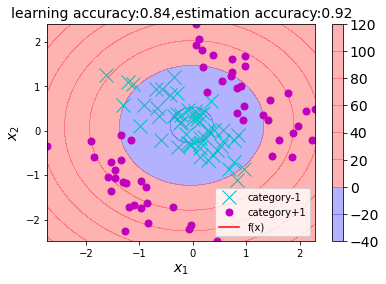

In [18]:
calculate(5, 1, 0.1, 0.5)
calculate(5, 1, 0.8, 0.5)
calculate(5, 1, 1, 0.5)
calculate(5, 1, 3, 0.5)

     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -2.2915e+01 -1.2579e+02  1e+03  6e+00  4e-15
 1: -1.1030e+01 -9.5469e+01  2e+02  7e-01  3e-15
 2: -7.2110e+00 -3.9596e+01  5e+01  1e-01  4e-15
 3: -7.4265e+00 -1.2806e+01  6e+00  1e-02  2e-15
 4: -8.3018e+00 -1.1178e+01  3e+00  5e-03  1e-15
 5: -8.7489e+00 -1.0251e+01  2e+00  2e-03  2e-15
 6: -9.0922e+00 -9.6193e+00  6e-01  6e-04  1e-15
 7: -9.1743e+00 -9.4246e+00  3e-01  6e-05  2e-15
 8: -9.2760e+00 -9.2940e+00  2e-02  3e-06  2e-15
 9: -9.2840e+00 -9.2842e+00  2e-04  3e-08  2e-15
10: -9.2841e+00 -9.2841e+00  2e-06  3e-10  2e-15
Optimal solution found.
model parameter:
w=[[ 2.53013798]
 [-0.16326566]
 [ 3.31082535]
 [ 2.35869971]
 [-0.28708993]
 [ 1.29556654]
 [-0.50756958]
 [ 4.44320779]
 [ 4.94857146]
 [-0.06288939]
 [ 2.07445948]
 [ 0.02161874]
 [ 2.97008476]
 [ 0.35583556]
 [ 1.8163965 ]
 [ 5.52280718]
 [ 4.18927828]
 [-0.06624172]
 [ 2.77990483]
 [ 3.83245381]
 [ 3.99284667]
 [ 2.07021132]
 [-0.42412397]
 [ 2.50822452]
 [ 7.24480

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.4455e+01 -1.0873e+02  9e+02  5e+00  3e-14
 1: -6.9031e+00 -7.6509e+01  1e+02  4e-01  3e-14
 2: -5.8227e+00 -3.5252e+01  4e+01  1e-01  2e-14
 3: -5.6645e+00 -2.1394e+01  2e+01  6e-02  1e-14
 4: -5.5412e+00 -1.1842e+01  8e+00  2e-02  2e-14
 5: -5.7778e+00 -7.3682e+00  2e+00  3e-03  2e-14
 6: -5.9589e+00 -6.3491e+00  4e-01  3e-16  2e-14
 7: -6.0758e+00 -6.1250e+00  5e-02  2e-16  2e-14
 8: -6.0895e+00 -6.1064e+00  2e-02  4e-16  2e-14
 9: -6.0961e+00 -6.0983e+00  2e-03  4e-16  1e-14
10: -6.0970e+00 -6.0971e+00  5e-05  2e-16  2e-14
11: -6.0971e+00 -6.0971e+00  9e-07  2e-16  2e-14
Optimal solution found.
model parameter:
w=[[ 4.26591702e+00]
 [-3.20618244e-02]
 [ 5.60477397e+00]
 [ 3.00945799e+00]
 [-9.22684443e-02]
 [ 1.07064948e+00]
 [-4.02644041e-01]
 [ 6.44147108e+00]
 [ 1.24738288e+01]
 [ 2.12955959e-03]
 [ 3.45796160e+00]
 [-1.52501798e-02]
 [ 5.07436935e+00]
 [ 1.26695887e-01]
 [ 2.45473469e+00]
 [ 1.72707791e+01]
 [ 2.93405131e+00

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


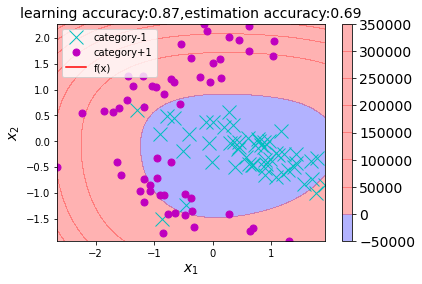

In [16]:
calculate(6, 2, 1, 0.5)
calculate(6, 2, 2, 0.5)
calculate(6, 2, 3, 0.5)
calculate(6, 2, 4, 0.5)

     pcost       dcost       gap    pres   dres
 0: -3.1519e+01 -1.0124e+02  4e+02  3e+00  3e-16
 1: -2.6853e+01 -7.6729e+01  5e+01  3e-15  3e-16
 2: -2.9687e+01 -3.4536e+01  5e+00  2e-16  3e-16
 3: -3.1563e+01 -3.2365e+01  8e-01  4e-16  2e-16
 4: -3.1849e+01 -3.2000e+01  2e-01  2e-15  2e-16
 5: -3.1914e+01 -3.1925e+01  1e-02  2e-16  2e-16
 6: -3.1920e+01 -3.1921e+01  5e-04  2e-16  2e-16
 7: -3.1920e+01 -3.1920e+01  1e-05  3e-16  2e-16
Optimal solution found.
model parameter:
w=[[ 0.62566288]
 [-0.82029171]
 [ 0.62566286]
 [ 0.62566306]
 [-1.33963485]
 [ 0.48821766]
 [-1.3691975 ]
 [ 0.512679  ]
 [ 0.49999965]
 [-0.56260793]
 [ 0.62565   ]
 [-0.69395545]
 [ 0.62566286]
 [-0.75171492]
 [ 0.5644655 ]
 [ 0.50435938]
 [-0.27313521]
 [-0.64010959]
 [ 0.53502446]
 [ 0.58013195]
 [ 0.51571437]
 [ 0.56630458]
 [-1.12093406]
 [ 0.57888567]
 [ 0.50242758]
 [-1.37433707]
 [-0.51255456]
 [-0.91409399]
 [ 0.52108305]
 [ 0.62566299]
 [-1.37433674]
 [ 0.49208095]
 [ 0.62566293]
 [ 0.62566202]
 [-1.37

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.5826e+01 -1.1397e+02  9e+02  5e+00  6e-16
 1: -8.5907e+00 -8.5795e+01  9e+01  1e-01  5e-16
 2: -9.4011e+00 -2.0833e+01  1e+01  1e-02  5e-16
 3: -1.0868e+01 -1.3613e+01  3e+00  3e-03  4e-16
 4: -1.1494e+01 -1.2424e+01  9e-01  6e-04  3e-16
 5: -1.1782e+01 -1.1930e+01  1e-01  8e-06  3e-16
 6: -1.1825e+01 -1.1870e+01  4e-02  1e-06  3e-16
 7: -1.1840e+01 -1.1847e+01  7e-03  1e-07  3e-16
 8: -1.1843e+01 -1.1843e+01  4e-04  6e-09  4e-16
 9: -1.1843e+01 -1.1843e+01  7e-06  9e-11  4e-16
Optimal solution found.
model parameter:
w=[[ 0.48673187]
 [-1.5132683 ]
 [ 0.57774125]
 [ 0.50666198]
 [-1.7081082 ]
 [-0.35873043]
 [-1.84103926]
 [ 0.66996873]
 [ 0.48673163]
 [-1.43136399]
 [ 0.27302065]
 [-1.73194538]
 [ 0.4867317 ]
 [-1.42781782]
 [ 0.3105257 ]
 [ 0.7628054 ]
 [ 0.57870668]
 [-1.51326782]
 [ 0.55254538]
 [ 0.64034921]
 [ 0.65521582]
 [ 0.25273603]
 [-1.72014021]
 [ 0.49143963]
 [ 0.53678567]
 [-1.87390335]
 [-1.51326749]
 [-1.86002514]

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-3-9e23bc9c82e6>:99: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


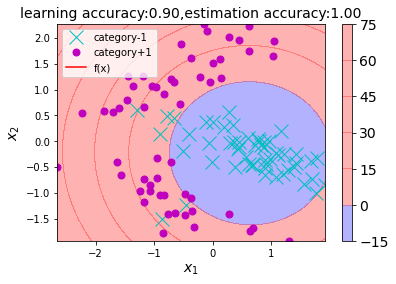

In [18]:
calculate(6, 1, 0.1, 0.5)
calculate(6, 1, 0.8, 0.5)
calculate(6, 1, 1, 0.5)
calculate(6, 1, 3, 0.5)

## 交差検証法によるハイパーパラメータの推定
ここではカーネルパラメータを推定する  
カーネルパラメータはガウスカーネルではカーネル関数の幅、多項式カーネルではカーネル関数の次数を表すものである

In [5]:
def closs_validation(dataType, kernelType):

    # 1. データの作成
    myData = data.classification(negLabel=-1.0,posLabel=1.0)
    myData.makeData(dataType)
    
    # 2. データを学習と評価用に分割
    dNum = int(len(myData.X)*0.9)  # 学習データ数
    # 学習データ（全体の90%）
    Xtr = myData.X[:dNum]
    Ytr = myData.Y[:dNum]
    
    # 評価データ（全体の10%）
    Xte = myData.X[dNum:]
    Yte = myData.Y[dNum:]
    
    # 3. 標準化
    xMean = np.mean(Xtr,axis=0)
    xStd = np.std(Xtr,axis=0)
    Xtr = (Xtr-xMean)/xStd
    Xte = (Xte-xMean)/xStd
    
    # 3.5. モデル選択
    # ハイパーパラメータの候補
    if kernelType == 1: # ガウスカーネルの幅
        kernelParams = [0.1,0.25,0.5,0.8,1.0,1.2,1.5,1.8,2.0,2.5,3.0]
    elif kernelType == 2: # 多項式カーネルのオーダー
        kernelParams = [1.0,2.0,3.0,4.0,5.0]

    # fold数
    foldNum = 5

    # 各foldで用いる学習データ数
    dNumFold = int(dNum/foldNum)

    # ランダムにデータを並べ替える
    randInds = np.random.permutation(len(Xtr))

    # 正解率を格納する変数
    accuracies = np.zeros([len(kernelParams),foldNum])

    # ハイパーパラメータの候補のループ
    for paramInd in range(len(kernelParams)):

        # 交差検証によ正解率の推定
        for foldInd in range(foldNum):
        
            # 学習データ数dNumFold分左にシフト
            randIndsTmp = np.roll(randInds,-dNumFold*foldInd)
            
            # 学習と評価データの分割
            XtrTmp = Xtr[randIndsTmp[dNumFold:]]
            YtrTmp = Ytr[randIndsTmp[dNumFold:]]
            XteTmp = Xtr[randIndsTmp[:dNumFold]]
            YteTmp = Ytr[randIndsTmp[:dNumFold]]
    
            try:
                # 手順1) SVMのモデルの学習
                myKernel = kernelFunc(kernelType=kernelType,kernelParam=kernelParams[paramInd])
                myModel = SVM(XtrTmp,YtrTmp,kernelFunc=myKernel)
                myModel.trainSoft(0.5)
            except:
                continue
    
            # 手順2) 評価データに対する正解率を格納
            accuracies[paramInd,foldInd] = myModel.accuracy(XteTmp,YteTmp)

    # 手順3) 平均正解率が最大のパラメータ
    selectedParam = kernelParams[np.argmax(np.mean(accuracies,axis=1))]
    print(f"selected parameter:{selectedParam}")
    
    # 3.75 正解率のプロット
    plt.plot(kernelParams,np.mean(accuracies,axis=1),'r-o',lineWidth=2)
    plt.xlabel("kernel parameter",fontSize=14)
    plt.ylabel("estimated accuracy",fontSize=14)
    plt.savefig(f"results/kernelSVM_CV_{myData.dataType}_{kernelType}.pdf")
    
    # 4. カーネル関数の作成
    myKernel = kernelFunc(kernelType=kernelType,kernelParam=selectedParam)
    
    # 5. SVMのモデルの学習
    myModel = SVM(Xtr,Ytr,kernelFunc=myKernel)
    myModel.trainSoft(0.5)
    
    # 6. SVMモデルの評価
    print(f"model parameter:\nw={myModel.w}\nb={myModel.b}")
    print(f"accuracy of estimation data={myModel.accuracy(Xte,Yte):.2f}")
    
    # 7. 真値と予測値のプロット
    myModel.plotModel2D(X=Xtr,Y=Ytr,xLabel=myData.xLabel,yLabel=myData.yLabel,
        title=f"learning accuracy:{myModel.accuracy(Xtr,Ytr):.2f},estimation accuracy:{myModel.accuracy(Xte,Yte):.2f}",
        fName=f"results/kernelSVM_result_{myData.dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.png",
        isLinePlot=False)

     pcost       dcost       gap    pres   dres
 0: -2.5459e+01 -7.5802e+01  3e+02  3e+00  4e-16
 1: -2.2088e+01 -5.6615e+01  3e+01  5e-16  3e-16
 2: -2.4486e+01 -2.7784e+01  3e+00  3e-16  3e-16
 3: -2.5957e+01 -2.6437e+01  5e-01  2e-16  2e-16
 4: -2.6163e+01 -2.6233e+01  7e-02  7e-16  2e-16
 5: -2.6200e+01 -2.6204e+01  5e-03  1e-15  2e-16
 6: -2.6202e+01 -2.6202e+01  1e-04  9e-16  2e-16
 7: -2.6202e+01 -2.6202e+01  2e-06  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.4976e+01 -7.9638e+01  3e+02  3e+00  4e-16
 1: -2.1469e+01 -6.0118e+01  4e+01  2e-15  3e-16
 2: -2.3691e+01 -2.7413e+01  4e+00  2e-16  3e-16
 3: -2.5081e+01 -2.5737e+01  7e-01  2e-15  2e-16
 4: -2.5295e+01 -2.5380e+01  8e-02  1e-15  2e-16
 5: -2.5322e+01 -2.5332e+01  1e-02  2e-15  2e-16
 6: -2.5326e+01 -2.5327e+01  8e-04  7e-16  2e-16
 7: -2.5326e+01 -2.5326e+01  4e-05  4e-16  2e-16
 8: -2.5326e+01 -2.5326e+01  1e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost 

 7: -8.2685e+00 -8.2685e+00  2e-05  7e-16  3e-16
 8: -8.2685e+00 -8.2685e+00  4e-07  2e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0824e+01 -8.3941e+01  6e+02  5e+00  5e-16
 1: -6.2371e+00 -6.1777e+01  6e+01  7e-02  5e-16
 2: -7.2107e+00 -1.5478e+01  8e+00  9e-03  4e-16
 3: -8.4497e+00 -1.0681e+01  2e+00  2e-03  4e-16
 4: -8.8780e+00 -9.6784e+00  8e-01  5e-04  2e-16
 5: -9.0659e+00 -9.3204e+00  3e-01  1e-04  2e-16
 6: -9.1438e+00 -9.2017e+00  6e-02  2e-16  3e-16
 7: -9.1655e+00 -9.1698e+00  4e-03  3e-16  3e-16
 8: -9.1672e+00 -9.1673e+00  1e-04  6e-16  4e-16
 9: -9.1673e+00 -9.1673e+00  3e-06  3e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1576e+01 -8.3952e+01  6e+02  5e+00  4e-16
 1: -6.9900e+00 -6.2069e+01  6e+01  1e-02  4e-16
 2: -8.2558e+00 -1.6390e+01  8e+00  2e-03  5e-16
 3: -9.5788e+00 -1.1835e+01  2e+00  4e-04  3e-16
 4: -1.0142e+01 -1.0667e+01  5e-01  6e-05  3e-16
 5: -1.0286e+01 -1.0430

 6: -1.9889e+01 -1.9899e+01  1e-02  4e-16  6e-16
 7: -1.9892e+01 -1.9895e+01  3e-03  2e-16  6e-16
 8: -1.9894e+01 -1.9894e+01  6e-05  2e-16  6e-16
 9: -1.9894e+01 -1.9894e+01  6e-07  2e-16  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.2072e+01 -9.7333e+01  7e+02  5e+00  7e-16
 1: -1.3889e+01 -7.6468e+01  7e+01  5e-02  7e-16
 2: -1.5075e+01 -2.2260e+01  7e+00  6e-03  6e-16
 3: -1.7154e+01 -1.8930e+01  2e+00  1e-03  5e-16
 4: -1.7817e+01 -1.8186e+01  4e-01  2e-04  5e-16
 5: -1.7974e+01 -1.8017e+01  4e-02  1e-05  5e-16
 6: -1.7991e+01 -1.7996e+01  5e-03  1e-06  7e-16
 7: -1.7993e+01 -1.7993e+01  1e-04  2e-09  7e-16
 8: -1.7993e+01 -1.7993e+01  4e-06  4e-11  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.5638e+01 -9.7271e+01  6e+02  5e+00  7e-16
 1: -1.6145e+01 -7.6651e+01  6e+01  6e-16  7e-16
 2: -1.8027e+01 -2.4693e+01  7e+00  2e-16  7e-16
 3: -2.0242e+01 -2.1894e+01  2e+00  6e-16  7e-16
 4: -2.0807e+01 -2.1250

<ipython-input-30-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


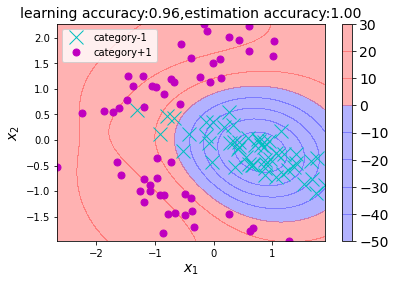

In [38]:
closs_validation(4, 1)

     pcost       dcost       gap    pres   dres
 0: -2.6027e+01 -7.5971e+01  3e+02  3e+00  3e-16
 1: -2.2501e+01 -5.6808e+01  3e+01  5e-16  3e-16
 2: -2.5025e+01 -2.8219e+01  3e+00  6e-16  3e-16
 3: -2.6607e+01 -2.6999e+01  4e-01  2e-16  2e-16
 4: -2.6795e+01 -2.6851e+01  6e-02  3e-16  2e-16
 5: -2.6826e+01 -2.6829e+01  3e-03  7e-16  2e-16
 6: -2.6828e+01 -2.6828e+01  1e-04  1e-15  2e-16
 7: -2.6828e+01 -2.6828e+01  7e-06  7e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.5338e+01 -7.6860e+01  3e+02  3e+00  4e-16
 1: -2.1881e+01 -5.7568e+01  4e+01  5e-16  2e-16
 2: -2.4201e+01 -2.7718e+01  4e+00  6e-16  3e-16
 3: -2.5509e+01 -2.6203e+01  7e-01  1e-15  2e-16
 4: -2.5764e+01 -2.5855e+01  9e-02  2e-15  2e-16
 5: -2.5793e+01 -2.5804e+01  1e-02  2e-15  2e-16
 6: -2.5798e+01 -2.5799e+01  9e-04  2e-15  2e-16
 7: -2.5799e+01 -2.5799e+01  8e-05  4e-16  2e-16
 8: -2.5799e+01 -2.5799e+01  1e-06  9e-16  2e-16
Optimal solution found.
     pcost       dcost 

 1: -6.5062e+00 -4.9114e+01  4e+01  6e-16  4e-16
 2: -7.9215e+00 -1.3078e+01  5e+00  2e-16  5e-16
 3: -9.1777e+00 -1.0652e+01  1e+00  1e-16  3e-16
 4: -9.5754e+00 -9.9728e+00  4e-01  7e-16  3e-16
 5: -9.7170e+00 -9.7817e+00  6e-02  2e-16  3e-16
 6: -9.7421e+00 -9.7491e+00  7e-03  7e-16  3e-16
 7: -9.7451e+00 -9.7454e+00  3e-04  2e-16  4e-16
 8: -9.7452e+00 -9.7452e+00  8e-06  5e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.5104e+00 -6.9244e+01  4e+02  4e+00  5e-16
 1: -6.4572e+00 -4.8708e+01  4e+01  5e-16  5e-16
 2: -7.8229e+00 -1.4032e+01  6e+00  3e-16  5e-16
 3: -9.2093e+00 -1.0665e+01  1e+00  7e-16  3e-16
 4: -9.7113e+00 -9.9401e+00  2e-01  2e-15  4e-16
 5: -9.7922e+00 -9.8201e+00  3e-02  2e-15  4e-16
 6: -9.8030e+00 -9.8048e+00  2e-03  1e-15  3e-16
 7: -9.8037e+00 -9.8038e+00  8e-05  2e-16  4e-16
 8: -9.8037e+00 -9.8037e+00  2e-06  2e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2287e+01 -7.4452

 7: -2.7902e+01 -2.7904e+01  2e-03  4e-16  8e-16
 8: -2.7903e+01 -2.7903e+01  3e-05  9e-16  8e-16
 9: -2.7903e+01 -2.7903e+01  3e-07  1e-15  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3097e+01 -9.1048e+01  5e+02  4e+00  9e-16
 1: -2.3526e+01 -7.1628e+01  5e+01  9e-16  8e-16
 2: -2.6437e+01 -3.2201e+01  6e+00  1e-15  8e-16
 3: -2.8309e+01 -2.9353e+01  1e+00  8e-16  8e-16
 4: -2.8625e+01 -2.9160e+01  5e-01  3e-16  7e-16
 5: -2.8760e+01 -2.8971e+01  2e-01  5e-16  8e-16
 6: -2.8826e+01 -2.8889e+01  6e-02  2e-16  8e-16
 7: -2.8852e+01 -2.8858e+01  6e-03  4e-16  9e-16
 8: -2.8854e+01 -2.8855e+01  2e-04  7e-16  9e-16
 9: -2.8855e+01 -2.8855e+01  2e-06  2e-16  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1507e+01 -9.0175e+01  5e+02  4e+00  8e-16
 1: -2.2711e+01 -7.0792e+01  5e+01  6e-16  9e-16
 2: -2.5657e+01 -3.1295e+01  6e+00  2e-16  6e-16
 3: -2.8082e+01 -2.9067e+01  1e+00  8e-16  7e-16
 4: -2.8384e+01 -2.8678

<ipython-input-30-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


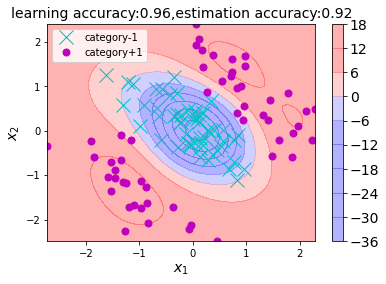

In [39]:
closs_validation(5, 1)

     pcost       dcost       gap    pres   dres
 0: -4.0614e+01 -1.0748e+02  8e+02  6e+00  2e-15
 1: -1.9866e+01 -8.6367e+01  1e+02  4e-01  2e-15
 2: -1.8511e+01 -2.8851e+01  1e+01  3e-16  5e-15
 3: -2.1443e+01 -2.3996e+01  3e+00  1e-16  1e-15
 4: -2.2095e+01 -2.3328e+01  1e+00  2e-16  9e-16
 5: -2.2402e+01 -2.2904e+01  5e-01  3e-16  1e-15
 6: -2.2554e+01 -2.2732e+01  2e-01  2e-16  8e-16
 7: -2.2629e+01 -2.2648e+01  2e-02  2e-16  1e-15
 8: -2.2638e+01 -2.2638e+01  2e-04  2e-16  1e-15
 9: -2.2638e+01 -2.2638e+01  2e-06  3e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5538e+01 -1.0499e+02  8e+02  6e+00  1e-15
 1: -1.7184e+01 -8.2902e+01  1e+02  4e-01  1e-15
 2: -1.4860e+01 -2.5784e+01  1e+01  6e-16  2e-15
 3: -1.7433e+01 -1.9871e+01  2e+00  2e-16  1e-15
 4: -1.8005e+01 -1.9235e+01  1e+00  2e-16  1e-15
 5: -1.8392e+01 -1.8734e+01  3e-01  2e-16  9e-16
 6: -1.8521e+01 -1.8583e+01  6e-02  5e-16  1e-15
 7: -1.8550e+01 -1.8551e+01  1e-03  2e-16  1e-1

 2: -2.6559e+00 -1.5871e+01  2e+01  8e-02  5e-14
 3: -2.3912e+00 -7.6116e+00  7e+00  3e-02  3e-14
 4: -2.1430e+00 -4.8178e+00  4e+00  1e-02  2e-14
 5: -1.9934e+00 -3.4437e+00  2e+00  6e-03  3e-14
 6: -1.8479e+00 -2.6437e+00  1e+00  2e-03  6e-14
 7: -1.7792e+00 -1.9603e+00  3e-01  4e-04  3e-14
 8: -1.7782e+00 -1.7904e+00  1e-02  5e-06  3e-14
 9: -1.7828e+00 -1.7848e+00  2e-03  7e-07  2e-14
10: -1.7837e+00 -1.7846e+00  9e-04  4e-08  2e-14
11: -1.7841e+00 -1.7841e+00  9e-06  5e-10  3e-14
12: -1.7841e+00 -1.7841e+00  9e-08  5e-12  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.4425e+00 -6.7627e+01  5e+02  4e+00  9e-14
 1: -3.9479e+00 -4.4103e+01  8e+01  5e-01  1e-13
 2: -2.8284e+00 -1.4777e+01  2e+01  9e-02  6e-14
 3: -2.5216e+00 -7.3895e+00  7e+00  3e-02  3e-14
 4: -2.2737e+00 -4.8072e+00  4e+00  1e-02  1e-14
 5: -2.1380e+00 -3.7391e+00  3e+00  7e-03  1e-14
 6: -1.8963e+00 -2.6931e+00  1e+00  2e-03  3e-14
 7: -1.8966e+00 -2.1253e+00  3e-01  6e-04  3e-

<ipython-input-30-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


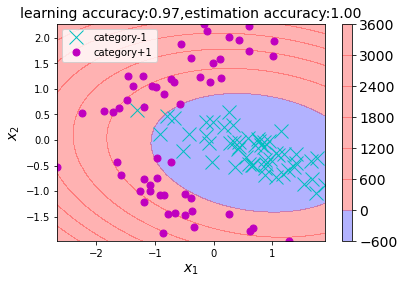

In [40]:
closs_validation(4, 2)

     pcost       dcost       gap    pres   dres
 0: -6.1819e+01 -1.0168e+02  6e+02  5e+00  2e-15
 1: -3.1160e+01 -8.3787e+01  6e+01  7e-02  2e-15
 2: -3.4847e+01 -4.0868e+01  6e+00  7e-03  1e-15
 3: -3.7312e+01 -3.8915e+01  2e+00  2e-03  1e-15
 4: -3.7998e+01 -3.8298e+01  3e-01  2e-04  2e-15
 5: -3.8139e+01 -3.8171e+01  3e-02  2e-05  2e-15
 6: -3.8155e+01 -3.8156e+01  1e-03  7e-07  2e-15
 7: -3.8155e+01 -3.8155e+01  1e-05  7e-09  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.4801e+01 -9.1643e+01  4e+02  4e+00  2e-15
 1: -3.4266e+01 -7.5176e+01  4e+01  1e-15  2e-15
 2: -4.0139e+01 -4.2962e+01  3e+00  9e-16  1e-15
 3: -4.1049e+01 -4.2712e+01  2e+00  1e-15  1e-15
 4: -4.1746e+01 -4.2230e+01  5e-01  8e-16  1e-15
 5: -4.1934e+01 -4.2039e+01  1e-01  8e-16  1e-15
 6: -4.1982e+01 -4.1991e+01  9e-03  7e-16  1e-15
 7: -4.1988e+01 -4.1988e+01  2e-04  4e-16  2e-15
 8: -4.1988e+01 -4.1988e+01  2e-06  3e-16  1e-15
Optimal solution found.
     pcost       dcost 

 6: -4.6527e-01 -1.0908e+00  9e-01  2e-03  3e-14
 7: -4.4733e-01 -5.0769e-01  6e-02  2e-05  4e-14
 8: -4.6965e-01 -4.7592e-01  7e-03  2e-06  1e-14
 9: -4.7241e-01 -4.7293e-01  5e-04  2e-16  6e-15
10: -4.7265e-01 -4.7266e-01  6e-06  2e-16  1e-14
11: -4.7265e-01 -4.7265e-01  6e-08  2e-16  7e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.6420e+00 -5.9109e+01  4e+02  4e+00  2e-13
 1: -2.4719e+00 -3.5368e+01  6e+01  3e-01  1e-13
 2: -1.5705e+00 -1.3512e+01  2e+01  8e-02  6e-14
 3: -1.5603e+00 -6.7922e+00  7e+00  3e-02  3e-14
 4: -1.5459e+00 -4.1823e+00  4e+00  1e-02  2e-14
 5: -1.1689e+00 -3.2040e+00  3e+00  8e-03  2e-14
 6: -9.7005e-01 -2.1386e+00  2e+00  3e-03  5e-14
 7: -9.7958e-01 -1.1758e+00  3e-01  3e-04  1e-14
 8: -1.0203e+00 -1.0324e+00  1e-02  6e-06  2e-14
 9: -1.0251e+00 -1.0258e+00  8e-04  4e-07  1e-14
10: -1.0254e+00 -1.0254e+00  1e-05  4e-09  9e-15
11: -1.0254e+00 -1.0254e+00  1e-07  4e-11  1e-14
Optimal solution found.
selected parameter:2.0

<ipython-input-30-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


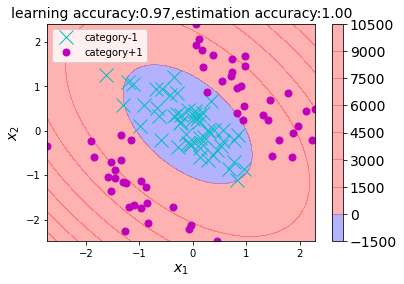

In [41]:
closs_validation(5, 2)

     pcost       dcost       gap    pres   dres
 0: -2.6519e+01 -8.1598e+01  3e+02  3e+00  3e-16
 1: -2.2588e+01 -6.1854e+01  4e+01  8e-16  3e-16
 2: -2.5185e+01 -2.8818e+01  4e+00  2e-16  3e-16
 3: -2.6958e+01 -2.7676e+01  7e-01  1e-15  2e-16
 4: -2.7349e+01 -2.7447e+01  1e-01  4e-16  2e-16
 5: -2.7404e+01 -2.7411e+01  7e-03  1e-15  2e-16
 6: -2.7408e+01 -2.7409e+01  2e-04  1e-15  2e-16
 7: -2.7408e+01 -2.7408e+01  6e-06  9e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6744e+01 -8.2831e+01  4e+02  3e+00  4e-16
 1: -2.2398e+01 -6.2975e+01  4e+01  5e-16  4e-16
 2: -2.4790e+01 -2.8635e+01  4e+00  9e-16  3e-16
 3: -2.6190e+01 -2.6828e+01  6e-01  2e-15  2e-16
 4: -2.6374e+01 -2.6459e+01  8e-02  3e-16  2e-16
 5: -2.6397e+01 -2.6404e+01  7e-03  1e-15  2e-16
 6: -2.6399e+01 -2.6400e+01  6e-04  1e-15  2e-16
 7: -2.6399e+01 -2.6399e+01  5e-05  1e-15  2e-16
 8: -2.6399e+01 -2.6399e+01  4e-06  8e-16  2e-16
Optimal solution found.
     pcost       dcost 

 4: -1.0106e+01 -1.0975e+01  9e-01  4e-04  3e-16
 5: -1.0348e+01 -1.0500e+01  2e-01  2e-15  3e-16
 6: -1.0391e+01 -1.0414e+01  2e-02  7e-16  3e-16
 7: -1.0399e+01 -1.0400e+01  2e-03  1e-15  4e-16
 8: -1.0399e+01 -1.0400e+01  7e-05  1e-15  3e-16
 9: -1.0400e+01 -1.0400e+01  1e-06  8e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2851e+01 -9.1432e+01  7e+02  5e+00  5e-16
 1: -7.3695e+00 -6.8944e+01  7e+01  6e-02  5e-16
 2: -8.2449e+00 -1.6172e+01  8e+00  7e-03  4e-16
 3: -9.5069e+00 -1.1343e+01  2e+00  1e-03  3e-16
 4: -9.9360e+00 -1.0612e+01  7e-01  3e-04  3e-16
 5: -1.0112e+01 -1.0270e+01  2e-01  5e-05  3e-16
 6: -1.0166e+01 -1.0186e+01  2e-02  3e-06  3e-16
 7: -1.0173e+01 -1.0175e+01  2e-03  3e-07  3e-16
 8: -1.0174e+01 -1.0174e+01  6e-05  7e-09  2e-16
 9: -1.0174e+01 -1.0174e+01  7e-07  8e-11  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1592e+01 -9.0038e+01  7e+02  5e+00  5e-16
 1: -6.4210e+00 -6.7352

 1: -1.7630e+01 -8.1056e+01  6e+01  2e-03  8e-16
 2: -1.9727e+01 -2.6696e+01  7e+00  2e-04  8e-16
 3: -2.2542e+01 -2.3689e+01  1e+00  2e-05  7e-16
 4: -2.3089e+01 -2.3228e+01  1e-01  1e-06  7e-16
 5: -2.3144e+01 -2.3165e+01  2e-02  2e-07  8e-16
 6: -2.3155e+01 -2.3155e+01  6e-04  2e-09  8e-16
 7: -2.3155e+01 -2.3155e+01  1e-05  4e-11  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2474e+01 -1.0283e+02  7e+02  5e+00  1e-15
 1: -1.9447e+01 -8.2398e+01  6e+01  6e-16  1e-15
 2: -2.1787e+01 -2.8276e+01  6e+00  1e-15  8e-16
 3: -2.4442e+01 -2.5750e+01  1e+00  2e-16  6e-16
 4: -2.5063e+01 -2.5328e+01  3e-01  5e-16  5e-16
 5: -2.5199e+01 -2.5229e+01  3e-02  3e-16  6e-16
 6: -2.5215e+01 -2.5217e+01  2e-03  9e-16  8e-16
 7: -2.5216e+01 -2.5216e+01  2e-05  2e-15  7e-16
Optimal solution found.
selected parameter:0.5
     pcost       dcost       gap    pres   dres
 0: -1.4646e+01 -1.1218e+02  8e+02  5e+00  5e-16
 1: -8.8439e+00 -8.4729e+01  8e+01  5e-02  5e-16


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.3832e+01 -1.1091e+02  9e+02  6e+00  2e-15
 1: -2.1016e+01 -8.9461e+01  1e+02  3e-01  2e-15
 2: -2.0583e+01 -2.9014e+01  9e+00  6e-03  1e-15
 3: -2.3456e+01 -2.5571e+01  2e+00  1e-03  1e-15
 4: -2.4219e+01 -2.4902e+01  7e-01  3e-04  1e-15
 5: -2.4458e+01 -2.4663e+01  2e-01  8e-05  1e-15
 6: -2.4553e+01 -2.4572e+01  2e-02  6e-06  1e-15
 7: -2.4562e+01 -2.4564e+01  2e-03  6e-07  1e-15
 8: -2.4563e+01 -2.4563e+01  4e-05  8e-09  1e-15
 9: -2.4563e+01 -2.4563e+01  9e-07  1e-10  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.9350e+01 -1.0931e+02  9e+02  6e+00  2e-15
 1: -1.8871e+01 -8.7180e+01  1e+02  4e-01  2e-15
 2: -1.7377e+01 -2.6790e+01  9e+00  6e-16  2e-15
 3: -2.0271e+01 -2.2430e+01  2e+00  7e-16  1e-15
 4: -2.0702e+01 -2.2057e+01  1e+00  2e-16  1e-15
 5: -2.1062e+01 -2.1564e+01  5e-01  1e-15  1e-15
 6: -2.1249e+01 -2.1370e+01  1e-01  1e-15  1e-15
 7: -2.1297e+01 -2.1308e+01  1e-02  1e-15  1e-1

 1: -5.5067e+00 -6.1653e+01  1e+02  5e-01  1e-13
 2: -4.1369e+00 -2.6604e+01  3e+01  1e-01  7e-14
 3: -3.7213e+00 -1.1054e+01  1e+01  3e-02  4e-14
 4: -3.7832e+00 -7.5584e+00  5e+00  1e-02  3e-14
 5: -3.7566e+00 -5.6296e+00  2e+00  4e-03  5e-14
 6: -3.7422e+00 -4.2669e+00  7e-01  1e-03  4e-14
 7: -3.7636e+00 -3.8800e+00  1e-01  1e-15  4e-14
 8: -3.8035e+00 -3.8103e+00  7e-03  2e-16  7e-14
 9: -3.8066e+00 -3.8068e+00  2e-04  3e-16  8e-14
10: -3.8067e+00 -3.8067e+00  7e-06  3e-16  4e-14
11: -3.8067e+00 -3.8067e+00  2e-07  2e-16  5e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9272e+00 -8.1642e+01  7e+02  5e+00  2e-13
 1: -4.9806e+00 -5.6635e+01  1e+02  5e-01  1e-13
 2: -3.5295e+00 -2.3922e+01  3e+01  1e-01  1e-13
 3: -3.0792e+00 -1.0957e+01  1e+01  3e-02  6e-14
 4: -2.8206e+00 -7.6329e+00  6e+00  1e-02  4e-14
 5: -2.9689e+00 -5.3071e+00  3e+00  3e-03  5e-14
 6: -3.2426e+00 -3.6472e+00  4e-01  4e-04  3e-14
 7: -3.3066e+00 -3.4502e+00  2e-01  1e-04  3e-

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


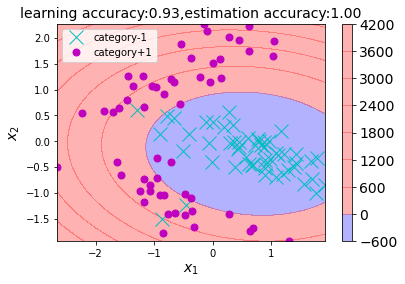

In [27]:
closs_validation(6, 1)

     pcost       dcost       gap    pres   dres
 0: -4.3832e+01 -1.1091e+02  9e+02  6e+00  2e-15
 1: -2.1016e+01 -8.9461e+01  1e+02  3e-01  2e-15
 2: -2.0583e+01 -2.9014e+01  9e+00  6e-03  1e-15
 3: -2.3456e+01 -2.5571e+01  2e+00  1e-03  1e-15
 4: -2.4219e+01 -2.4902e+01  7e-01  3e-04  1e-15
 5: -2.4458e+01 -2.4663e+01  2e-01  8e-05  1e-15
 6: -2.4553e+01 -2.4572e+01  2e-02  6e-06  1e-15
 7: -2.4562e+01 -2.4564e+01  2e-03  6e-07  1e-15
 8: -2.4563e+01 -2.4563e+01  4e-05  8e-09  1e-15
 9: -2.4563e+01 -2.4563e+01  9e-07  1e-10  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.9350e+01 -1.0931e+02  9e+02  6e+00  2e-15
 1: -1.8871e+01 -8.7180e+01  1e+02  4e-01  2e-15
 2: -1.7377e+01 -2.6790e+01  9e+00  6e-16  2e-15
 3: -2.0271e+01 -2.2430e+01  2e+00  7e-16  1e-15
 4: -2.0702e+01 -2.2057e+01  1e+00  2e-16  1e-15
 5: -2.1062e+01 -2.1564e+01  5e-01  1e-15  1e-15
 6: -2.1249e+01 -2.1370e+01  1e-01  1e-15  1e-15
 7: -2.1297e+01 -2.1308e+01  1e-02  1e-15  1e-1

 1: -5.3903e+00 -6.0854e+01  1e+02  4e-01  4e-14
 2: -4.4561e+00 -3.1798e+01  4e+01  1e-01  2e-14
 3: -4.1664e+00 -1.8806e+01  2e+01  7e-02  1e-14
 4: -3.7971e+00 -9.7538e+00  8e+00  2e-02  2e-14
 5: -4.0657e+00 -5.7868e+00  2e+00  4e-03  4e-14
 6: -4.2577e+00 -4.6789e+00  5e-01  8e-04  1e-14
 7: -4.3246e+00 -4.4177e+00  9e-02  1e-15  1e-14
 8: -4.3481e+00 -4.3796e+00  3e-02  2e-16  1e-14
 9: -4.3582e+00 -4.3652e+00  7e-03  6e-16  1e-14
10: -4.3611e+00 -4.3613e+00  2e-04  2e-16  1e-14
11: -4.3612e+00 -4.3612e+00  2e-06  5e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.4366e+00 -8.2446e+01  7e+02  5e+00  4e-14
 1: -4.5299e+00 -5.6017e+01  8e+01  3e-01  2e-14
 2: -4.0360e+00 -2.1320e+01  2e+01  8e-02  1e-14
 3: -3.9465e+00 -1.4157e+01  1e+01  4e-02  1e-14
 4: -3.9866e+00 -6.5865e+00  3e+00  8e-03  2e-14
 5: -3.9438e+00 -4.6313e+00  8e-01  1e-03  6e-15
 6: -4.0106e+00 -4.1679e+00  2e-01  3e-04  9e-15
 7: -4.0382e+00 -4.0761e+00  4e-02  4e-05  8e-

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


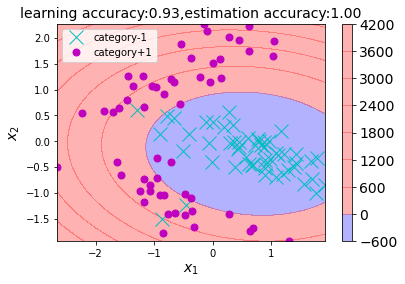

In [32]:
closs_validation(6, 2)

     pcost       dcost       gap    pres   dres
 0: -6.2034e+01 -3.4647e+02  4e+03  7e+00  6e-15
 1: -2.9670e+01 -2.7456e+02  7e+02  1e+00  5e-15
 2: -1.4234e+01 -1.1499e+02  2e+02  2e-01  9e-15
 3: -7.2189e+00 -2.3660e+01  2e+01  2e-02  1e-14
 4: -8.4454e+00 -1.3377e+01  6e+00  4e-03  5e-15
 5: -8.9701e+00 -1.1923e+01  3e+00  2e-03  2e-15
 6: -9.4408e+00 -1.0926e+01  2e+00  1e-03  2e-15
 7: -9.6907e+00 -1.0347e+01  7e-01  3e-04  1e-15
 8: -9.7461e+00 -1.0199e+01  5e-01  2e-04  1e-15
 9: -9.8993e+00 -9.9698e+00  7e-02  1e-05  2e-15
10: -9.9216e+00 -9.9426e+00  2e-02  3e-06  2e-15
11: -9.9307e+00 -9.9320e+00  1e-03  6e-16  2e-15
12: -9.9313e+00 -9.9314e+00  1e-05  3e-16  2e-15
13: -9.9314e+00 -9.9314e+00  1e-07  2e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.8451e+01 -4.0436e+02  5e+03  8e+00  8e-15
 1: -3.2093e+01 -3.3261e+02  9e+02  1e+00  7e-15
 2: -1.6484e+01 -1.5958e+02  2e+02  2e-01  6e-15
 3: -7.8963e+00 -3.5898e+01  4e+01  3e-02  8e-1

15: -2.6366e+00 -2.6366e+00  3e-06  4e-11  9e-15
16: -2.6366e+00 -2.6366e+00  3e-08  4e-13  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7874e+01 -2.5402e+02  2e+03  5e+00  9e-14
 1: -9.0573e+00 -1.7839e+02  4e+02  7e-01  9e-14
 2: -5.3975e+00 -6.8967e+01  1e+02  2e-01  1e-13
 3: -2.5453e+00 -2.2039e+01  3e+01  5e-02  2e-14
 4: -1.7233e+00 -7.9648e+00  1e+01  1e-02  4e-14
 5: -1.4396e+00 -7.1332e+00  8e+00  9e-03  9e-15
 6: -1.5527e+00 -4.2688e+00  4e+00  4e-03  5e-15
 7: -1.5784e+00 -2.8596e+00  2e+00  1e-03  8e-15
 8: -1.7063e+00 -2.0341e+00  4e-01  3e-04  3e-14
 9: -1.6978e+00 -1.8735e+00  2e-01  7e-05  2e-14
10: -1.7493e+00 -1.7610e+00  1e-02  1e-06  2e-14
11: -1.7550e+00 -1.7551e+00  2e-04  2e-08  6e-15
12: -1.7551e+00 -1.7551e+00  2e-06  2e-10  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1845e+01 -2.5168e+02  2e+03  5e+00  1e-13
 1: -1.1010e+01 -1.7684e+02  4e+02  7e-01  9e-14
 2: -6.7093e+00 -7.0138

     pcost       dcost       gap    pres   dres
 0: -8.1406e+01 -5.2576e+02  7e+03  8e+00  8e-15
 1: -3.7713e+01 -4.3450e+02  1e+03  1e+00  7e-15
 2: -1.8985e+01 -2.0575e+02  3e+02  2e-01  1e-14
 3: -7.4043e+00 -3.8650e+01  4e+01  2e-02  1e-14
 4: -9.1275e+00 -1.8773e+01  1e+01  5e-03  4e-15
 5: -1.0009e+01 -1.5868e+01  7e+00  3e-03  2e-15
 6: -1.0633e+01 -1.4136e+01  4e+00  1e-03  2e-15
 7: -1.1233e+01 -1.2652e+01  2e+00  4e-04  1e-15
 8: -1.1681e+01 -1.1902e+01  2e-01  5e-06  1e-15
 9: -1.1766e+01 -1.1801e+01  4e-02  7e-07  2e-15
10: -1.1781e+01 -1.1783e+01  2e-03  9e-09  2e-15
11: -1.1782e+01 -1.1782e+01  2e-05  9e-11  2e-15
12: -1.1782e+01 -1.1782e+01  2e-07  9e-13  3e-15
Optimal solution found.
model parameter:
w=[[-5.83407998e-01]
 [-2.51119596e-01]
 [ 1.59088668e+00]
 [ 1.23017613e+00]
 [ 2.22516046e+00]
 [ 2.42077174e+00]
 [-6.05028368e+00]
 [ 2.84585012e+00]
 [-1.64505899e+00]
 [-5.43491592e-01]
 [ 5.18493059e+00]
 [ 8.99559616e-01]
 [ 2.87730257e+00]
 [-4.97452609e+00]
 [-4.9

<ipython-input-3-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


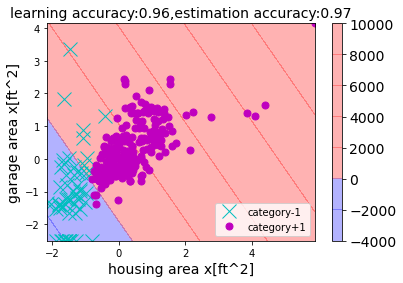

In [6]:
closs_validation(2, 2)

     pcost       dcost       gap    pres   dres
 0: -3.2305e+01 -2.1484e+02  1e+03  4e+00  6e-16
 1: -2.7187e+01 -1.4733e+02  1e+02  1e-01  4e-16
 2: -2.6956e+01 -4.0114e+01  1e+01  8e-03  4e-16
 3: -2.7693e+01 -2.9447e+01  2e+00  5e-04  2e-16
 4: -2.7849e+01 -2.8233e+01  4e-01  9e-05  2e-16
 5: -2.7886e+01 -2.7978e+01  9e-02  2e-05  2e-16
 6: -2.7896e+01 -2.7924e+01  3e-02  4e-06  2e-16
 7: -2.7901e+01 -2.7906e+01  6e-03  2e-07  2e-16
 8: -2.7901e+01 -2.7903e+01  1e-03  2e-16  2e-16
 9: -2.7902e+01 -2.7902e+01  9e-05  2e-15  2e-16
10: -2.7902e+01 -2.7902e+01  2e-06  4e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.4818e+01 -2.1397e+02  1e+03  4e+00  5e-16
 1: -2.9618e+01 -1.4717e+02  1e+02  8e-02  4e-16
 2: -2.9590e+01 -4.2458e+01  1e+01  7e-03  4e-16
 3: -3.0408e+01 -3.2007e+01  2e+00  4e-04  2e-16
 4: -3.0551e+01 -3.0853e+01  3e-01  6e-05  2e-16
 5: -3.0585e+01 -3.0647e+01  6e-02  1e-05  2e-16
 6: -3.0593e+01 -3.0612e+01  2e-02  3e-06  2e-1

11: -1.1852e+01 -1.1853e+01  8e-04  1e-15  3e-16
12: -1.1853e+01 -1.1853e+01  2e-05  2e-16  3e-16
13: -1.1853e+01 -1.1853e+01  5e-07  6e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2763e+01 -2.1168e+02  1e+03  4e+00  5e-16
 1: -8.7454e+00 -1.3817e+02  2e+02  9e-02  5e-16
 2: -9.7470e+00 -3.0227e+01  2e+01  1e-02  6e-16
 3: -1.1621e+01 -1.6967e+01  5e+00  2e-03  4e-16
 4: -1.2277e+01 -1.4106e+01  2e+00  3e-04  3e-16
 5: -1.2595e+01 -1.3064e+01  5e-01  5e-05  3e-16
 6: -1.2686e+01 -1.2845e+01  2e-01  1e-05  3e-16
 7: -1.2728e+01 -1.2758e+01  3e-02  2e-15  3e-16
 8: -1.2737e+01 -1.2745e+01  8e-03  5e-16  3e-16
 9: -1.2739e+01 -1.2742e+01  4e-03  2e-15  3e-16
10: -1.2740e+01 -1.2741e+01  4e-04  4e-15  3e-16
11: -1.2740e+01 -1.2740e+01  8e-06  2e-15  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3154e+01 -2.0764e+02  1e+03  4e+00  5e-16
 1: -8.9485e+00 -1.3466e+02  1e+02  9e-02  5e-16
 2: -9.9282e+00 -3.0470

10: -1.3028e+01 -1.3028e+01  3e-05  5e-16  6e-16
11: -1.3028e+01 -1.3028e+01  4e-07  1e-15  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7848e+01 -2.1338e+02  2e+03  4e+00  7e-16
 1: -1.0636e+01 -1.3925e+02  2e+02  2e-01  7e-16
 2: -1.0131e+01 -2.7872e+01  2e+01  2e-02  8e-16
 3: -1.2392e+01 -1.8111e+01  6e+00  4e-03  6e-16
 4: -1.3192e+01 -1.6196e+01  3e+00  1e-03  5e-16
 5: -1.3757e+01 -1.4688e+01  9e-01  7e-05  5e-16
 6: -1.4055e+01 -1.4196e+01  1e-01  8e-16  6e-16
 7: -1.4115e+01 -1.4122e+01  7e-03  2e-16  6e-16
 8: -1.4118e+01 -1.4119e+01  3e-04  1e-16  6e-16
 9: -1.4119e+01 -1.4119e+01  3e-06  2e-15  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9001e+01 -2.2407e+02  2e+03  4e+00  7e-16
 1: -1.1223e+01 -1.4888e+02  2e+02  2e-01  6e-16
 2: -1.0509e+01 -2.9006e+01  2e+01  2e-02  1e-15
 3: -1.2506e+01 -2.0191e+01  8e+00  5e-03  7e-16
 4: -1.3631e+01 -1.6872e+01  3e+00  2e-03  5e-16
 5: -1.4015e+01 -1.5892

 7: -1.9831e+01 -1.9849e+01  2e-02  2e-06  9e-16
 8: -1.9838e+01 -1.9840e+01  2e-03  2e-07  9e-16
 9: -1.9839e+01 -1.9839e+01  2e-05  3e-09  9e-16
10: -1.9839e+01 -1.9839e+01  2e-07  3e-11  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7125e+01 -2.1975e+02  2e+03  4e+00  1e-15
 1: -1.5873e+01 -1.4769e+02  2e+02  2e-01  1e-15
 2: -1.4639e+01 -3.3304e+01  2e+01  2e-02  1e-15
 3: -1.7929e+01 -2.4225e+01  7e+00  4e-03  7e-16
 4: -1.9097e+01 -2.1802e+01  3e+00  2e-03  6e-16
 5: -1.9675e+01 -2.0797e+01  1e+00  4e-04  6e-16
 6: -2.0042e+01 -2.0222e+01  2e-01  5e-05  8e-16
 7: -2.0106e+01 -2.0126e+01  2e-02  3e-06  7e-16
 8: -2.0115e+01 -2.0115e+01  3e-04  5e-08  8e-16
 9: -2.0115e+01 -2.0115e+01  3e-06  5e-10  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6978e+01 -2.4560e+02  2e+03  5e+00  1e-15
 1: -1.5512e+01 -1.7114e+02  2e+02  2e-01  1e-15
 2: -1.3923e+01 -3.4810e+01  2e+01  2e-02  2e-15
 3: -1.7763e+01 -2.4618

<ipython-input-3-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


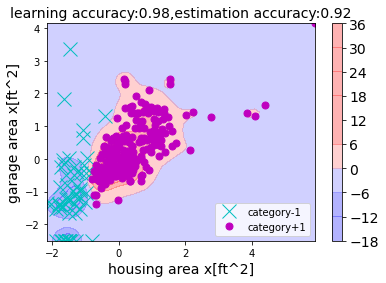

In [7]:
closs_validation(2,1)

## 学習にかかる時間の計算

     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]
 [ 2.14959375]
 [-0.05910411]
 [-0.62102946]
 [ 0.63588367]
 [ 2.04333591]
 [ 0.23054988]
 [-0.49458863]
 [ 2.53541552]
 [ 0.92427568]
 [-1.39007869]
 [ 0.46808058]
 [ 1.19466339]
 [-1.03789783]
 [ 0.08329429]
 [ 1.05746643]
 [ 1.66984984]
 [-0.37619027]
 [-0.8015584 ]
 [-2.72293378]
 [ 0.99818105]
 [-2.08631371]
 [ 1.01816088]
 [ 1.77944011]
 [-1.24213809]
 [-1.37631605]
 [ 1.40466187]
 [-0.89312097]
 [-0.97671786]
 [-0.80423239]
 [ 1.32958018]
 [ 1.28180086]
 [ 0.63210929]
 [-1.012

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]
 [ 2.14959375]
 [-0.05910411]
 [-0.62102946]
 [ 0.63588367]
 [ 2.04333591]
 [ 0.23054988]
 [-0.49458863]
 [ 2.53541552]
 [ 0.92427568]
 [-1.39007869]
 [ 0.46808058]
 [ 1.19466339]
 [-1.03789783]
 [ 0.08329429]
 [ 1.05746643]
 [ 1.66984984]
 [-0.37619027]
 [-0.8015584 ]
 [-2.72293378]
 [ 0.99818105]
 [-2.08631371]
 [ 1.01816088]
 [ 1.77944011]
 [-1.24213809]
 [-1.37631605]
 [ 1.40466187]
 [-0.89312097]
 [-0.97671786]
 [-0.80423239]
 [ 1.32958018]
 [ 1.28180086]
 [ 0.63210929]
 [-1.012

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]
 [ 2.14959375]
 [-0.05910411]
 [-0.62102946]
 [ 0.63588367]
 [ 2.04333591]
 [ 0.23054988]
 [-0.49458863]
 [ 2.53541552]
 [ 0.92427568]
 [-1.39007869]
 [ 0.46808058]
 [ 1.19466339]
 [-1.03789783]
 [ 0.08329429]
 [ 1.05746643]
 [ 1.66984984]
 [-0.37619027]
 [-0.8015584 ]
 [-2.72293378]
 [ 0.99818105]
 [-2.08631371]
 [ 1.01816088]
 [ 1.77944011]
 [-1.24213809]
 [-1.37631605]
 [ 1.40466187]
 [-0.89312097]
 [-0.97671786]
 [-0.80423239]
 [ 1.32958018]
 [ 1.28180086]
 [ 0.63210929]
 [-1.012

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]
 [ 2.14959375]
 [-0.05910411]
 [-0.62102946]
 [ 0.63588367]
 [ 2.04333591]
 [ 0.23054988]
 [-0.49458863]
 [ 2.53541552]
 [ 0.92427568]
 [-1.39007869]
 [ 0.46808058]
 [ 1.19466339]
 [-1.03789783]
 [ 0.08329429]
 [ 1.05746643]
 [ 1.66984984]
 [-0.37619027]
 [-0.8015584 ]
 [-2.72293378]
 [ 0.99818105]
 [-2.08631371]
 [ 1.01816088]
 [ 1.77944011]
 [-1.24213809]
 [-1.37631605]
 [ 1.40466187]
 [-0.89312097]
 [-0.97671786]
 [-0.80423239]
 [ 1

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


elasped time:39.860909938812256[sec]


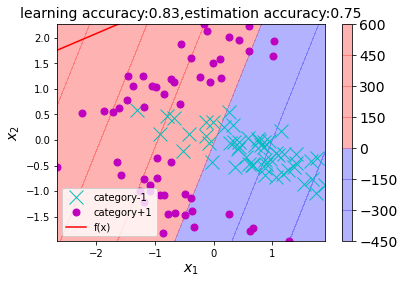

In [22]:
start = time.time()
for i in range(200):
    calculate(4, 0, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  7e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  5e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  4e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  4e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  2e-16  5e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  9e-16  3e-16
Optimal solution found.
model parameter:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


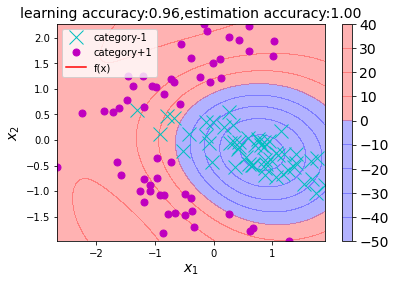

In [23]:
start = time.time()
for i in range(200):
    calculate(4, 1, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  1e-15  2e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  7e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  1e-15
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  1e-15
 7: -2.6163e+01 -2.6171e+01  8e-03  3e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  4e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.69937194]
 [-1.42947704]
 [-1.40579066]
 [ 1.23072228]
 [-1.07572447]
 [ 2.27363759]
 [-1.44959589]
 [ 2.3920771 ]
 [ 0.92427566]
 [-2.88831222]
 [ 1.35866909]
 [-0.16790754]
 [-1.46439497]
 [ 0.29280818]
 [ 1.09610334]
 [ 2.22602929]
 [ 3.5244295 ]
 [-2.40231528]
 [ 0.0692015 ]
 [ 0.20475786]
 [ 0.32355685]
 [ 1.84205204]
 [-1.93031591]
 [ 0.00607711]
 [ 0.43946077]
 [-1.18846846]
 [-1.52723773]
 [-0.85647747]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


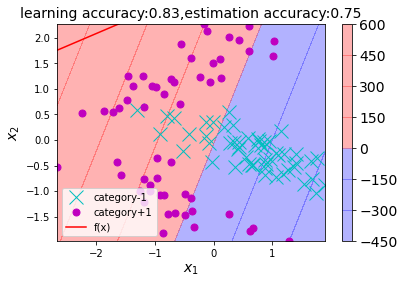

In [28]:
start = time.time()
for i in range(200):
    calculate(4, 2, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


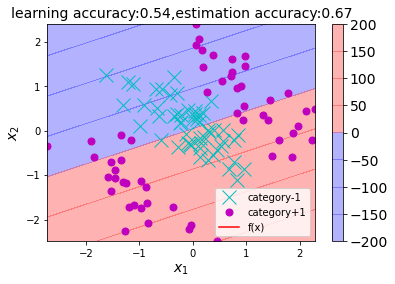

In [24]:
start = time.time()
for i in range(200):
    calculate(5, 0, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973316]
 [ 0.35966145]
 [ 0.72858898]
 [-1.6403346 ]
 [-1.83472077]
 [-1.68979957]
 [ 0.54010385]
 [-1.53085814]
 [ 0.25013368]
 [-1.26864358]
 [-0.68275403]
 [-1.67008014]
 [ 0.79570625]
 [ 0.61690618]
 [-1.79625538]
 [-1.94405553]
 [ 0.57065656]
 [-0.2887458 ]
 [-1.91098998]
 [-1.75328242]
 [ 0

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



accuracy of estimation data=0.92
elasped time:0.006616115570068359[sec]
     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973316]
 [ 0.35966145]
 [ 0.72858898]
 [-1.6403346 ]
 [-1.83472077]
 [-1.68979957]
 [ 0.54010385]
 [-1.53085814]
 [ 0.25013368]
 [-1.26864358]
 [-0.68275403]
 [-1.67008014]
 [ 0.79570625]
 [ 0.61690618]
 [-1.79625538]
 [-1.94405553]
 [ 0.57065656]


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973316]
 [ 0.35966145]
 [ 0.72858898]
 [-1.6403346 ]
 [-1.83472077]
 [-1.68979957]
 [ 0.54010385]
 [-1.53085814]
 [ 0.25013368]
 [-1.26864358]
 [-0.68275403]
 [-1.67008014]
 [ 0.79570625]
 [ 0.616906

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.9

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973316]
 [ 0.35966145]
 [ 0.72858898]
 [-1.6403346 ]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 0.61082195]
 [ 0.88545351]
 [ 0.68063307]
 [-1.91418997]
 [ 0.31361921]
 [ 0.84622975]
 [-1.96973316]
 [ 0.35966145]
 [ 0.72858898]
 [-1.6403346 ]
 [-1.83472077]
 [-1.68979957]
 [ 0.54010385]
 [-1.53085814]
 [ 0.25013368]
 [-1.26864358]
 [-0.68

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  5e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  6e-16  5e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  4e-16  5e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  2e-16  4e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  2e-16  4e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  6e-16  4e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  3e-16  4e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  2e-16  4e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  1e-15  4e-16
Optimal solution found.
model parameter:
w=[[ 0.05752041]
 [-1.81884579]
 [ 0.45375357]
 [ 0.63775406]
 [-1.92028424]
 [ 0.5132096 ]
 [-1.94538921]
 [ 0.92121189]
 [ 0.68306026]
 [-1.27444721]
 [ 0.53470573]
 [-1.70066619]
 [ 0.35966157]
 [-1.72704982]
 [ 0.35966101]
 [ 0.79353141]
 [ 0.43363185]
 [-1.56574098]
 [ 0.58866316]
 [-0.44295481]
 [ 0.37788843]
 [ 0.04181267]
 [-1.85023421]
 [ 0.65990451]
 [-0.38778764]
 [-1.65818339]
 [-0.86492954]
 [-1.96209305]
 [ 0.3222827 ]
 [ 0.68441856]
 [-1.89991131]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


elasped time:43.940340995788574[sec]


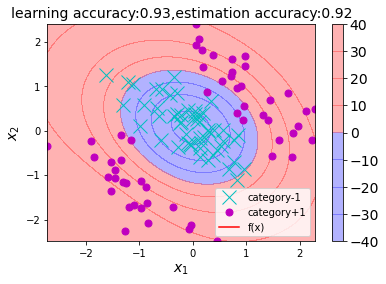

In [25]:
start = time.time()
for i in range(200):
    calculate(5, 1, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768584]
 [ 0.26985833]
 [ 0.10856527]
 [-0.26249134]
 [-0.43974641]
 [-1.05010529]
 [-0.49643959]
 [-0.63324606]
 [ 0.90709277]
 [ 0.98103304]
 [-0.43342313]
 [ 0.35182479]
 [ 0.10407718]
 [-0.53492273]
 [-0.08026447]
 [ 0.28011752]
 [-0.13114378]
 [ 0.89829114]
 [ 0.13263749]
 [-0.32099928]
 [ 0.134449  ]
 [-0.28770543]
 [ 0.60331009]
 [-0.164

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768584]
 [ 0.26985833]
 [ 0.10856527]
 [-0.26249134]
 [-0.43974641]
 [-1.05010529]
 [-0.49643959]
 [-

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768584]
 [ 0.26985833]
 [ 0.10856527]
 [-0.26249134]
 [-0.43974641]
 [-1.05010529]
 [-0.49643959]
 [-

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 0.91012575]
 [-0.52840128]
 [ 0.69984806]
 [-0.33200072]
 [-1.14920231]
 [ 0.53758591]
 [ 0.22768

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  3e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  8e-16  2e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  3e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-15  2e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-15  2e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  1e-15  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 0.00911063]
 [ 0.41119873]
 [ 1.31833838]
 [ 0.0027546 ]
 [ 0.17516689]
 [-0.90217246]
 [ 0.16203044]
 [-0.66716733]
 [ 0.22150745]
 [ 0.87815766]
 [-0.28115255]
 [-0.64570407]
 [ 1.27662196]
 [-0.82165376]
 [-0.08961273]
 [-0.71594597]
 [-0.78781143]
 [ 0.77013385]
 [ 0.66946752]
 [ 0.20193874]
 [ 0.3728877 ]
 [-0.80666145]
 [ 0.43417506]
 [ 0.71784641]
 [ 0.05761951]
 [-0.17847625]
 [-0.28219232]
 [-0.00306122]
 [-0.56564185]
 [ 0.94989445]
 [-0.29919792]
 [ 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


elasped time:46.354048013687134[sec]


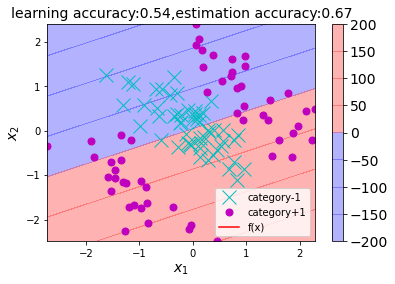

In [26]:
start = time.time()
for i in range(200):
    calculate(5, 2, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-0.6095148 ]
 [ 3.11080661]
 [ 0.44537682]
 [-0.965

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



accuracy of estimation data=0.69
elasped time:0.008384943008422852[sec]


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  1e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  2e-16  2e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  4e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  2e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  8e-16
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  7e-16  1e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  7e-16  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


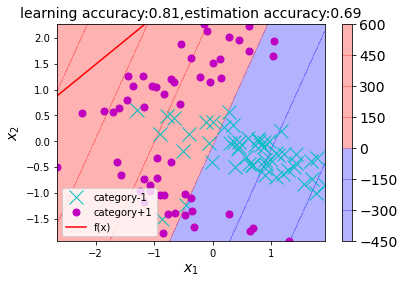

In [29]:
start = time.time()
for i in range(200):
    calculate(6, 0, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.89487083]
 [ 0.66732125]
 [ 0.39978394]
 [-1.83191943]
 [ 0.48606603]
 [ 0.63464865]
 [-1.89792358]
 [-1.60021561]
 [-0.58056338]
 [ 0.41424283]
 [-1.63215657]
 [ 0.49680292]
 [-1.35777833]
 [ 0.53857915]
 [-1.79615103]
 [ 0.39978389]
 [ 0.838465

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


accuracy of estimation data=1.00
elasped time:0.008901119232177734[sec]
     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


accuracy of estimation data=1.00
elasped time:0.007853984832763672[sec]
     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.8

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.89487083]
 [ 0.66732125]
 [ 0.39978394]
 [-1.83191943]
 [ 0.48606603]
 [ 0.63464865]
 [-1.89792358]
 [-1.60021561]
 [-0.58056338]
 [ 0.41424283]
 [-1.63215657]
 [ 0.49680292]
 [-1.35777833]
 [ 0.53

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.89487083]
 [ 0.66732125]
 [ 0.39978394]
 [-1.83191

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.89487083]
 [ 0.66732125]
 [ 0.39978394]
 [-1.83191943]
 [ 0.48606603]
 [ 0.63464865]
 [-1.89792358]
 [-1.60021561]
 [-0.58056338]
 [ 0.41424283]
 [-1.63215657]
 [ 0.49680292]
 [-1.35777833]
 [ 0.53857915]
 [-1.79615103]
 [ 0.39978389]
 [ 0.83846544]
 [-1.9417725 ]
 [-1.76812045]
 [ 0.16547474]


<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]
 [ 0.49892795]
 [ 0.42658764]
 [-1.9227618 ]
 [ 0.59896247]
 [ 0.42136644]
 [ 0.52224471]
 [-1.89487083]
 [ 0.66732125]
 [ 0.39978394]
 [-1.83191943]
 [ 0.48606603]
 [ 0.63464865]
 [-1.89792358]
 [-1.60021561]
 [-0.58056338]
 [ 0.41424283]
 [-1.63215657]
 [ 0.49680292]
 [-1.35777833]
 [ 0.53857915]
 [-1.79615103]
 [ 0.39978389]
 [ 0.83846544]
 [-1.9417725 ]
 [-1.76812045]
 [ 0.16547474]
 [ 0.76642144]
 [-1.77310497]
 [-1.90931615]
 [ 0.50444333]
 [ 0.44655586]
 [ 0.70155584]
 [-1.95468008]
 [-1.38504069]
 [-1.89814587]
 [-1.1554563 ]
 [ 0.13116432]
 [-1.8

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -1.7481e+01 -1.1846e+02  1e+03  5e+00  7e-16
 1: -9.1502e+00 -9.0045e+01  1e+02  1e-01  7e-16
 2: -1.0031e+01 -2.1735e+01  1e+01  1e-02  5e-16
 3: -1.1795e+01 -1.4950e+01  3e+00  3e-03  4e-16
 4: -1.2449e+01 -1.3573e+01  1e+00  8e-04  3e-16
 5: -1.2735e+01 -1.3030e+01  3e-01  1e-04  3e-16
 6: -1.2827e+01 -1.2898e+01  7e-02  1e-05  4e-16
 7: -1.2853e+01 -1.2860e+01  7e-03  1e-06  4e-16
 8: -1.2856e+01 -1.2856e+01  2e-04  2e-08  3e-16
 9: -1.2856e+01 -1.2856e+01  2e-06  2e-10  4e-16
Optimal solution found.
model parameter:
w=[[ 0.39978388]
 [-1.6002162 ]
 [ 0.39978399]
 [ 0.40989622]
 [-1.76749452]
 [-0.34679918]
 [-1.89324076]
 [ 0.62780911]
 [ 0.39978393]
 [-1.47113581]
 [ 0.13192222]
 [-1.62267341]
 [ 0.28870278]
 [-1.28759507]
 [ 0.18010139]
 [ 0.92752974]
 [ 0.61796013]
 [-1.52728819]
 [ 0.40737188]
 [ 0.62598435]
 [ 0.61620417]
 [ 0.19012758]
 [-1.76147202]
 [ 0.36728563]
 [ 0.66891536]
 [-1.91123342]
 [-1.61840616]
 [-1.87342923]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


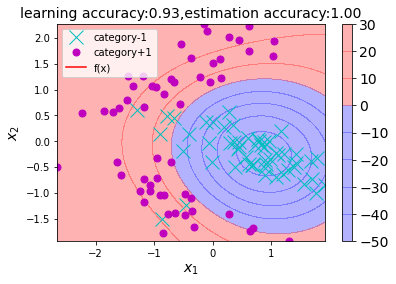

In [30]:
start = time.time()
for i in range(200):
    calculate(6, 1, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-0

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.4

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-0

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



accuracy of estimation data=0.69
elasped time:0.006999015808105469[sec]
     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.100172

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-0

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



accuracy of estimation data=0.69
elasped time:0.006777763366699219[sec]
     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)



accuracy of estimation data=0.69
elasped time:0.007851839065551758[sec]
     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.100172

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)
<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]
 [ 1.975827  ]
 [ 0.76591411]
 [-0.59186815]
 [ 0.42524051]
 [ 1.66099799]
 [ 0.07727945]
 [-0.47239534]
 [ 0.57438156]
 [ 1.24515323]
 [-1.35489648]
 [ 1.02615426]
 [ 2.03037508]
 [-0.97782822]
 [ 0.06895659]
 [ 1.02916465]
 [ 2.20374582]
 [-0.33047422]
 [ 1.38222553]
 [-2.65956703]
 [ 2.18464667]
 [-2.00648871]
 [-0.69319052]
 [ 1.10017221]
 [-1.1851677 ]
 [-1.34811243]
 [-0.89122873]
 [ 0.18021427]
 [-0.96566957]
 [-0.75727447]
 [-0.6095148 ]
 [ 3.11080661]
 [ 0.44537682]
 [-0.965

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


     pcost       dcost       gap    pres   dres
 0: -4.9465e+01 -1.3604e+02  1e+03  6e+00  2e-15
 1: -2.3946e+01 -1.0879e+02  1e+02  4e-01  2e-15
 2: -2.2028e+01 -3.4596e+01  1e+01  7e-16  3e-15
 3: -2.5635e+01 -2.8639e+01  3e+00  2e-16  1e-15
 4: -2.6495e+01 -2.7661e+01  1e+00  7e-16  1e-15
 5: -2.6800e+01 -2.7266e+01  5e-01  2e-16  1e-15
 6: -2.6992e+01 -2.7054e+01  6e-02  4e-16  1e-15
 7: -2.7019e+01 -2.7023e+01  4e-03  2e-15  2e-15
 8: -2.7021e+01 -2.7021e+01  8e-05  2e-15  1e-15
 9: -2.7021e+01 -2.7021e+01  1e-06  6e-16  1e-15
Optimal solution found.
model parameter:
w=[[ 1.30418558]
 [-1.41137108]
 [-1.49042831]
 [ 1.07093931]
 [-1.06109087]
 [ 0.99756943]
 [-1.40212642]
 [-0.1348454 ]
 [ 3.25995727]
 [-2.7996399 ]
 [ 0.51309254]
 [-0.13828771]
 [-1.53948087]
 [ 0.30330557]
 [ 0.95787734]
 [ 1.41692608]
 [ 0.56098927]
 [-2.34243162]
 [-0.06715357]
 [ 2.35854505]
 [-0.21583819]
 [ 1.44224708]
 [-1.8727295 ]
 [ 0.76610873]
 [ 0.05315298]
 [-1.12509389]
 [-1.42391255]
 [-0.84044822]

<ipython-input-12-9f8066f75060>:94: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


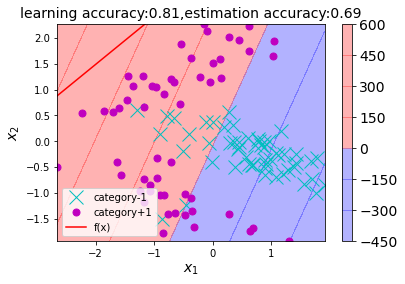

In [31]:
start = time.time()
for i in range(200):
    calculate(6, 2, 1, 0.5)
elapsed_time = time.time() - start
print("elasped time:{}".format(elapsed_time) + "[sec]")

In [39]:
myData = data.classification(negLabel=-1.0,posLabel=1.0)
myData.makeData(5)

# 2. データを学習と評価用に分割
dtrNum = int(len(myData.X)*0.9)  # 学習データ数
# 学習データ（全体の90%）
Xtr = myData.X[:dtrNum]
Ytr = myData.Y[:dtrNum]

# 評価データ（全体の10%）
Xte = myData.X[dtrNum:]
Yte = myData.Y[dtrNum:]
# 3. 標準化
xMean = np.mean(Xtr,axis=0)
xStd = np.std(Xtr,axis=0)
Xtr = (Xtr-xMean)/xStd
Xte = (Xte-xMean)/xStd
# 4. カーネル関数の作成
myKernel = kernelFunc(1,1)

# 5. SVMのモデルの学習
start = time.time()
Model = SVM(Xtr,Ytr,kernelFunc=myKernel)
Model.xDim

2